#Início: Carregando pacotes e objeto da análise

In [142]:
#Importando pacotes a serem utilizados: Astropy para ler o arquivo FITS, Scipy e Numpy para as análises e Pylab para as visualizações.

import scipy.optimize as opt
from scipy.ndimage import rotate
import numpy as np
import pylab as plt
from astropy.io import fits as fits
from tqdm import tqdm

In [143]:
#Carregando a imagem proveniente do SAOImage DS9
image = fits.getdata('m31.fits').astype(float)

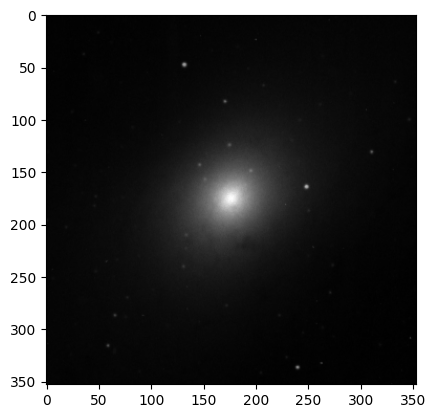

In [144]:
#Visualização incial da imagem
plt.imshow(image,cmap='gray')
plt.show()

#Primeiro passo - rotacionar a imagem a fim de eliminar uma das componentes da equação da elipse: o ângulo de rotação.

In [145]:
#Com a função rotate() do Scipy, a função a seguir facilitará o processo de encontrar a posição ideal
def rotation(data, angle):
  image_rotated = rotate(data, angle, reshape=False)
  return image_rotated

Para ajeitar a imagem a fim de deixar a galáxia em função dos eixos x e y apenas, sem nenhum ângulo de rotação, encontrarei o centro aproximado pelo método do momento linear e, analisando uma faixa passando por esse ponto, poderei analisar o fluxo máximo garantindo que a galáxia esteja alinhada com essa faixa.

In [146]:
#Função para análise do momento linear da imagem, calculando as intensidades dos pixels e atribuindo os pesos necessários.
def momento(data):
    I_i = np.sum(data, axis=0)
    I_j = np.sum(data, axis=1)
    Ii_mean = np.sum(I_i)/len(I_i)
    Ij_mean = np.sum(I_j)/len(I_j)

    x_i = np.arange(data.shape[1])
    y_j = np.arange(data.shape[0])
    mask_i = (I_i - Ii_mean) > 0
    mask_j = (I_j - Ij_mean) > 0

    xc = np.sum((I_i - Ii_mean)[mask_i]*x_i[mask_i])/np.sum((I_i - Ii_mean)[mask_i])
    yc = np.sum((I_j - Ij_mean)[mask_j]*y_j[mask_j])/np.sum((I_j - Ij_mean)[mask_j])
    return xc, yc

In [147]:
#O centro aproximado da imagem se dá, então, por:
x0, y0 = momento(image)
print(x0,y0)

174.97897942271953 174.37772651271126


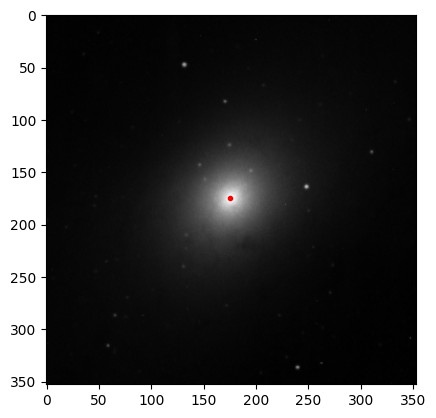

In [149]:
#Visualização do centro aproximado:
plt.imshow(image,cmap='gray')
plt.plot(x0,y0,'r.')
plt.show()

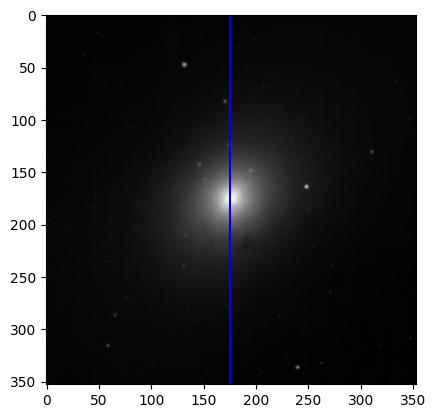

1524169.0

In [154]:
#A linha em azul mostra o fluxo que estou somando. A maximização dessa soma ocorre quando o eixo maior da elipse está alinhada verticalmente.
plt.imshow(image,cmap='gray')
plt.axvline(x0, color='b')
plt.show()

np.sum(image[:,int(y0)])

In [155]:
#A fim de analisar a variação do fluxo horizontal passando pelo centro da galáxia, o array fluxo_h vai armazenar esse valor para cada angulo de rotação
#até 180 graus.
angles = np.arange(0,180)
fluxo_h = np.array([])

for i in tqdm(angles):
  fluxo_h = np.append(fluxo_h, np.log10(np.sum(rotation(image,i)[:,int(y0)])))

100%|██████████| 180/180 [00:05<00:00, 30.91it/s]


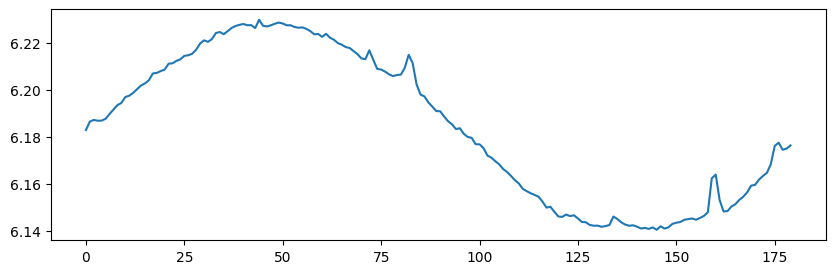

44

In [157]:
#Visualização dos fluxos horizontais em função do ângulo de rotação da imagem
plt.figure(figsize=[10,3])
plt.plot(angles,fluxo_h)
plt.show()

#O ângulo em que o fluxo é máximo é:
angles[np.argmax(fluxo_h)]

É claro que, por conta de outros objetos presentes na imagem, um ruído de fundo bem visível aparece dependendo do ângulo. Também é óbvio que esta distribuição tem a mesma forma de uma função seno, então um ajuste pode ajudar com a precisão.

In [159]:
def sin_fit(x, A, B, C, D):
    return A * np.sin(B * x + C) + D

In [160]:
# Chutes iniciais para os parâmetros da função seno
chute = [1, 1, 0, 0]
angles_rad = np.radians(angles)
params, params_cov = opt.curve_fit(sin_fit, angles_rad, fluxo_h, p0=chute)

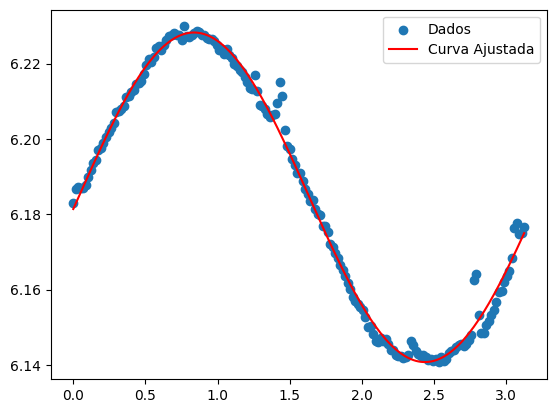

In [167]:
#Visualização da curva ajustada aos dados:
plt.scatter(angles_rad, fluxo_h, label="Dados")
plt.plot(angles_rad, sin_fit(angles_rad, *params), label="Curva Ajustada", color="red")
plt.legend()
plt.show()

In [169]:
#Agora, com a curva ajustada, podemos recuperar o ângulo que maximiza o fluxo total na linha horizontal que passa pelo centro da galáxia
print(angles[np.argmax(sin_fit(angles_rad, *params))],'é o ângulo que maximiza o fluxo na linha horizontal.')

48 é o ângulo que maximiza o fluxo na linha horizontal.


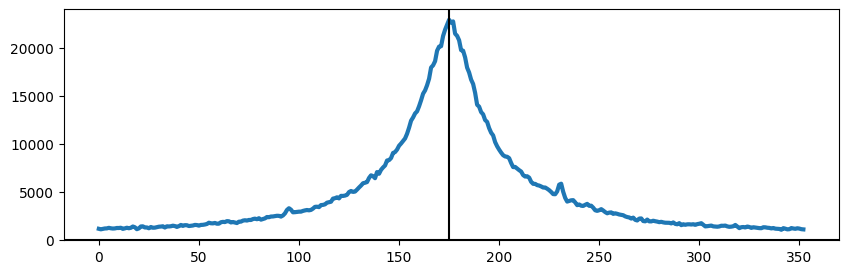

In [172]:
#Visuzalizando a distribuição da curva de luz através do centro da imagem e conferindo se o centro traz uma boa aproximação:
plt.figure(figsize=[10,3])
plt.plot(rotation(image,48)[:,int(y0)], lw=3)
plt.axhline(0, color='k')
plt.axvline(x0, color='k')

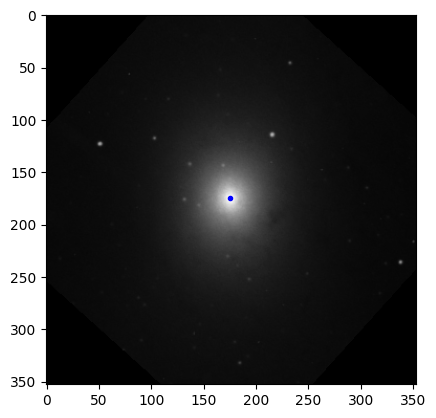

In [173]:
#Visuzalição da imagem rotacionada
plt.imshow(rotation(image,48),cmap='gray')
plt.plot(x0,y0,'b.')
plt.show()

In [174]:
#Redefinindo a imagem para levar em conta a rotação
image = rotation(image,48)

#Definindo a área para análise

##Como a galáxia é um objeto elíptico, agora que temos a imagem alinhada com os eixos x e y posso fazer uma análise em cada uma das dimensões diretamente. Primeiro verei como os semi-eixos menor e maior afetam a análise do fluxo

In [179]:
#Definindo os semi-eixos menor e maior, levando em consideração que o semi-eixo maior está na componente y, vou criar uma máscara para visualização diretamente na imagem
semi_M = 85
semi_m = 30

mask = np.sqrt(((x - x0)/semi_m)**2 + ((y - y0)/semi_M)**2) < 1

image_copy = np.copy(image)
image_copy[~mask] = np.nan

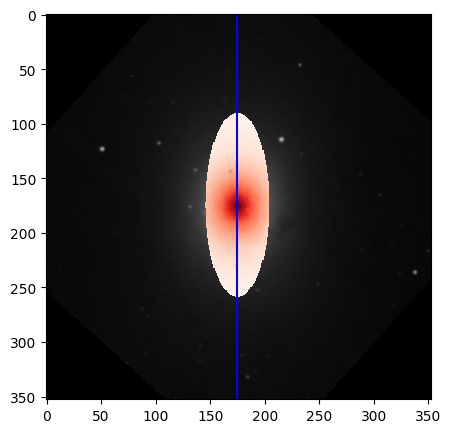

In [180]:
plt.figure(figsize=[5, 5])
plt.imshow(image, cmap='gray')
plt.imshow(image_copy, cmap='Reds')
plt.axvline(x0, color='blue', zorder=1)
plt.show()

Claramente os parâmetros não são os ideais.

In [209]:
#Visualizando a soma total do fluxo, em contagens, dentro da máscara criada e a quantidade de pixels

flux = np.sum(image[mask])
print(flux)

npix = len(image[mask])
print(npix)

43847994.13190792
5575


In [210]:
#Primeiramente vou análisar a variação do semi-eixo menor
fluxos = np.array([])
semi_m = np.arange(1,60)
semi_M = 30

for i in semi_m:
    mask = np.sqrt(((x - x0)/i)**2 + ((y - y0)/semi_M)**2) < 1
    fluxos = np.append(fluxos, np.sum(image[mask]))

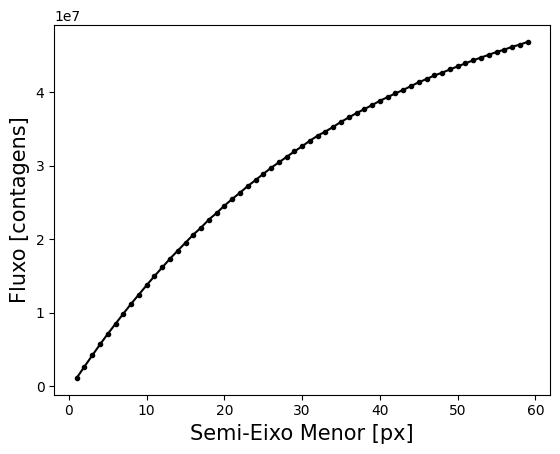

In [211]:
#Visualização da variação do fluxo, em contagens, com o tamanho do semi-eixo menor

plt.plot(semi_m, fluxos,  'k.-')
plt.xlabel('Semi-Eixo Menor [px]', fontsize=15)
plt.ylabel('Fluxo [contagens]', fontsize=15)
plt.show()

In [212]:
#Agora farei o mesmo para o semi-eixo maior:
fluxos = np.array([])
semi_M = np.arange(1,90)
semi_m = 20

for i in semi_M:
    mask = np.sqrt(((x - x0)/semi_m)**2 + ((y - y0)/i)**2) < 1
    fluxos = np.append(fluxos, np.sum(image[mask]))

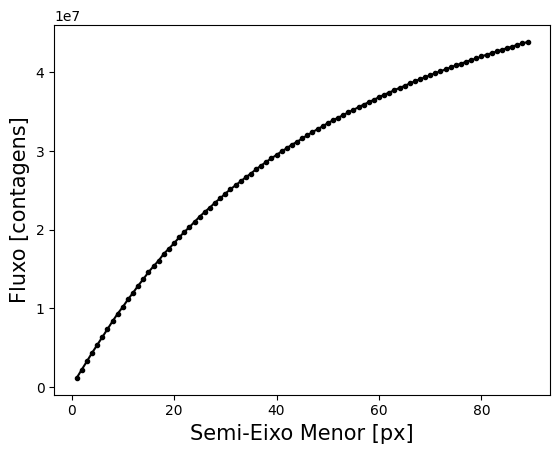

In [213]:
plt.plot(semi_M, fluxos,  'k.-')
plt.xlabel('Semi-Eixo Menor [px]', fontsize=15)
plt.ylabel('Fluxo [contagens]', fontsize=15)
plt.show()

##Pode-se ver que o fluxo aumenta conforme os semi-eixos, mas a presença de ruídos não é muito clara. Farei uma análise dos ruídos em seguida.

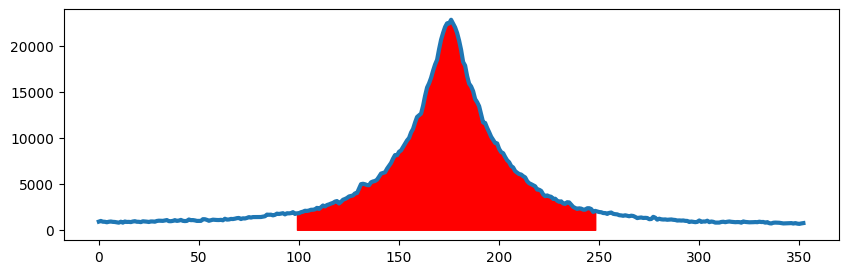

In [214]:
#Visualização da distribuição de fluxo
plt.figure(figsize=[10,3])
plt.plot(image[int(y0)], lw=3)
plt.fill_between(x = range(int(x0-75), int(x0+75)), color='red',
                y1=image[int(y0),int(x0)-75:int(x0)+75], y2=0)
plt.show()

Existe um ruído, mas parece ser muito pequeno para nossa imagem. Vou verificar com uma análise da área ao redor da galáxia:

In [215]:
#Definindo um anel elíptico ao redor da galáxia para analisar o fluxo de fundo:

outer_ring_m = 110
outer_ring_M = 150
inner_ring_m = 100
inner_ring_M = 140

mask_sky = ((np.sqrt(((x - x0)/outer_ring_m)**2 + ((y - y0)/outer_ring_M)**2) < 1) *
            (np.sqrt(((x - x0)/inner_ring_m)**2 + ((y - y0)/inner_ring_M)**2) > 1))


image_sky = np.copy(image)
image_sky[~mask_sky] = np.nan

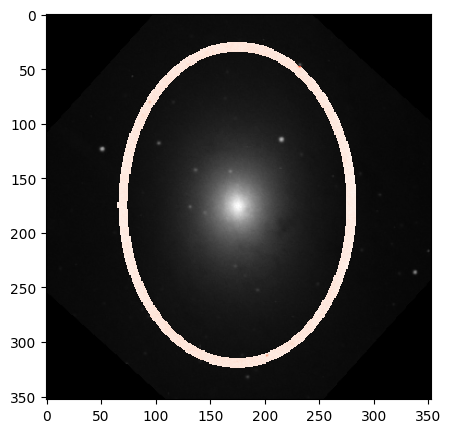

In [216]:
#Visualização da máscara
plt.figure(figsize=[5, 5])
plt.imshow(image, cmap='gray')
plt.imshow(image_sky, cmap='Reds')
plt.show()

In [217]:
#Analisando a média e o desvio padrão, podemos achar o ruído de fundo presente
print(round(image[mask_sky].mean(),1),
      '+/-',
      round(image[mask_sky].std(),1) )

1314.4 +/- 144.8


In [218]:
flux_sky = np.sum(image[mask_sky])
print('Fluxo do céu:', flux_sky)
npix_sky = len(image[mask_sky])
print('Número de pixels:', npix_sky)
print('Distribuição do fundo de céu:',round(image[mask_sky].mean(),2),'+/-', round(image[mask_sky].std(),2))

Fluxo do céu: 10319410.444894236
Número de pixels: 7851
Distribuição do fundo de céu: 1314.41 +/- 144.82


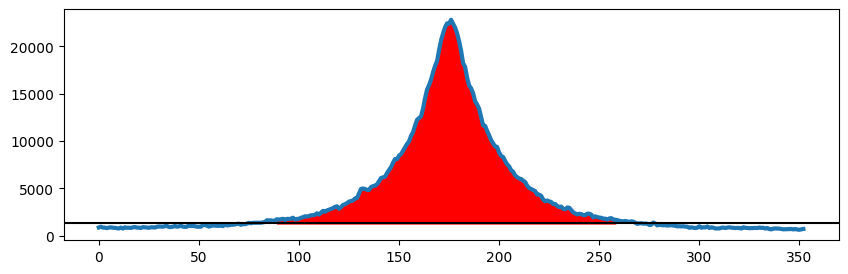

In [219]:
#Visualização da distribuição sem o fundo de céu
plt.figure(figsize=[10,3])
plt.plot(image[int(y0)], lw=3)
plt.axhline(1314.41, color='k')

plt.fill_between(x = range(int(x0-85), int(x0+85)), color='red',
                y1=image[int(y0),int(x0)-85:int(x0)+85], y2=1314.41)
plt.show()

In [221]:
#Assim, posso remover o fluxo atribuído a ruído de fundo
flux_actual = flux - npix*image[mask_sky].mean()

In [222]:
#Agora a razão Sinal-Ruído pode ser calculada de forma mais acurada:

snr = flux_actual/np.sqrt((flux_actual + npix*image[mask_sky].mean()))

print('S/N:', snr)

S/N: 5515.158226081435


In [223]:
#Repetindo a análise anterior para o semi-eixo menor, mas dessa vez calculando o sinal-ruído:
fluxos = np.array([])
npixs = np.array([])

semi_m = np.arange(1,210)
semi_M = 30

for i in semi_m:
    mask = np.sqrt(((x - x0)/i)**2 + ((y - y0)/semi_M)**2) < 1
    fluxos = np.append(fluxos, np.sum(image[mask]))
    npixs  = np.append(npixs, len(image[mask]))


flux_new = fluxos - npixs*image[mask_sky].mean()
snr = flux_new/np.sqrt(flux_new + npixs*image[mask_sky].mean())

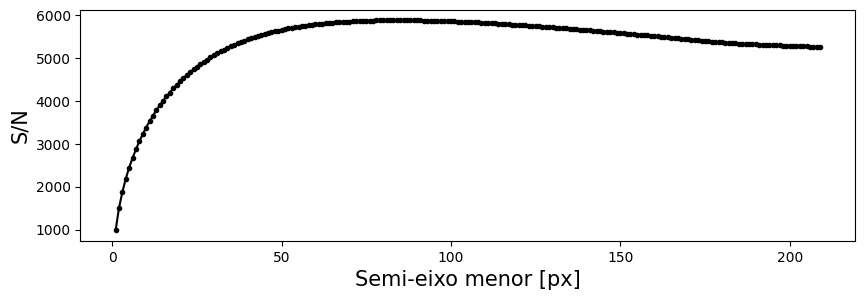

In [225]:
#Visualizando o S/N em função da variação do semi-eixo menor
plt.figure(figsize=[10,3])
plt.plot(semi_m, snr, 'k.-')
plt.xlabel('Semi-eixo menor [px]', fontsize=15)
plt.ylabel('S/N', fontsize=15)
plt.show()

Claramente temos um resultado para o valor do semi-eixo menor que maximiza a razão Sinal-Ruído

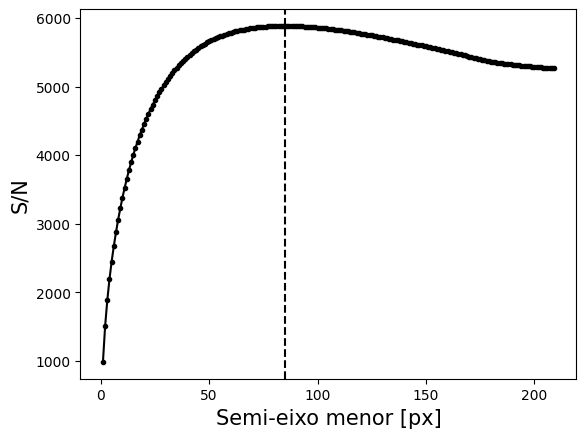


Melhor semi-eixo menor: 85


In [228]:
plt.plot(semi_m, snr, 'k.-')
plt.xlabel('Semi-eixo menor [px]', fontsize=15)
plt.ylabel('S/N', fontsize=15)
plt.axvline(semi_m[snr.argmax()], color='k', ls='--')
plt.show()
print('\nMelhor semi-eixo menor:', semi_m[snr.argmax()])

In [231]:
#Agora basta repetir para o semi-eixo maior, já utilizando o semi-eixo menor encontrado anteriormente:
fluxos = np.array([])
npixs = np.array([])

semi_m = 85
semi_M = np.arange(1,210)

for i in semi_M:
    mask = np.sqrt(((x - x0)/semi_m)**2 + ((y - y0)/i)**2) < 1
    fluxos = np.append(fluxos, np.sum(image[mask]))
    npixs  = np.append(npixs, len(image[mask]))


flux_new = fluxos - npixs*image[mask_sky].mean()
snr = flux_new/np.sqrt(flux_new + npixs*image[mask_sky].mean())

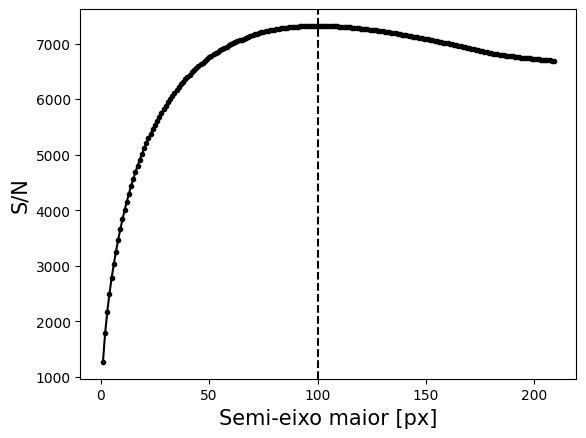


Melhor semi-eixo maior: 100


In [232]:
plt.plot(semi_M, snr, 'k.-')
plt.xlabel('Semi-eixo maior [px]', fontsize=15)
plt.ylabel('S/N', fontsize=15)
plt.axvline(semi_M[snr.argmax()], color='k', ls='--')
plt.show()
print('\nMelhor semi-eixo maior:', semi_M[snr.argmax()])

Assim, os melhores semi-eixos encontrados foram 85 e 100.

In [233]:
#Repetindo a máscara anterior para visualização, agora com os semi-eixos encontrados:
semi_m = 85
semi_M = 100

mask = np.sqrt(((x - x0)/semi_m)**2 + ((y - y0)/semi_M)**2) < 1

image_copy = np.copy(image)
image_copy[~mask] = np.nan

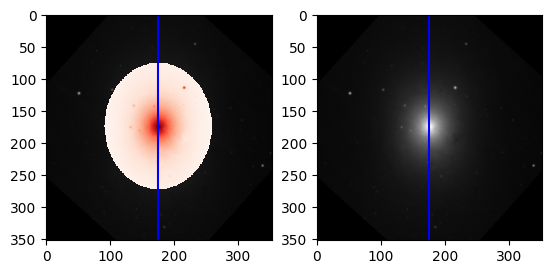

In [239]:
#Visualização lado a lado da máscara e da galáxia:

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.imshow(image_copy, cmap='Reds')
plt.axvline(x0, color='blue', zorder=1)

plt.subplot(1, 2, 2)
plt.imshow(image, cmap='gray')
plt.axvline(x0, color='blue', zorder=1)

plt.show()

Com isso basta calcular o fluxo total dentro da área encontrada:

In [245]:
fluxo = np.sum(image[mask])
npix = len(image[mask])

print('O fluxo total em {} pixels é de {:.2f} contagens.'.format(npix,fluxo))

O fluxo total em 26695 pixels é de 112792865.30 contagens.
